In [1]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.autograd import Variable
import tools.utils as utils
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import animation, rc
from torch.optim import LBFGS
import numpy as np
from IPython.display import display, Math, Latex, Markdown, HTML
import pandas as pd
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [2]:
device = "cuda"

In [3]:
target_pcd = torch.tensor(utils.pcl_from_pcd("../dataset/map.pcd"), device=device, dtype=torch.float32)[:,:2]
#target_pcd = torch.tensor(utils.pcl_from_pcd("../exercises/dataset/target.pcd"), device=device, dtype=torch.float32)[:,:2]
target_pcd.shape

torch.Size([143949, 2])

In [4]:
class NDT_map():
    def __init__(self, grid_map, means, covs, counts, resolution, x_min, y_min, distributions) -> None:
        self.grid_map = grid_map
        self.means = means
        self.covs = covs
        self.counts = counts
        self.nx = grid_map.shape[0]
        self.ny = grid_map.shape[1]
        self.x_min = x_min
        self.y_min = y_min
        self.resolution = resolution
        self.distributions = distributions
        

In [5]:
def voxelize(pcd, x_min, x_max, y_min, y_max, resolution, ratio = 1.5):
    """Voxelize a point cloud.
    Args:
        pcd: point cloud, shape (N, 3)
        x_min, x_max, y_min, y_max: voxelization range
        resolution: voxel size
    Returns:
        voxelized pcd, shape (N, 3)
    """
    points = pcd.clone()
    map = torch.zeros(
        (nx := int(torch.ceil((x_max - x_min) / resolution)),
        ny := int(torch.ceil((y_max - y_min) / resolution)), 2), device=device, dtype=torch.float32)
    # write cell centers to map
    map[:,:,0], map[:,:,1] = torch.meshgrid(
        torch.arange(x_min, x_max, resolution, device=device),
        torch.arange(y_min, y_max, resolution, device=device)
        )
    offset = torch.zeros((1,2), device=device, dtype=torch.float32)
    offset[0,0] = x_min
    offset[0,1] = y_min
    pcd = pcd - offset
    pcd = pcd / resolution
    pcd = pcd.round()
    pcd[:,0] = torch.clamp(pcd[:,0], 0, nx-1)
    pcd[:,1] = torch.clamp(pcd[:,1], 0, ny-1)
    pcd = pcd.to(torch.int64)

    pcd_ = torch.unique(pcd, dim=0)
    counts_map = torch.zeros((nx,ny), device=device, dtype=torch.int64)

    means = torch.zeros((map.shape[0],map.shape[1],2), device=device, dtype=torch.float32)
    covs = torch.zeros((map.shape[0],map.shape[1],2,2), device=device, dtype=torch.float32)
    distributions = np.zeros((map.shape[0],map.shape[1]), dtype=object)

    sizes = []
    for idx in pcd_:
        # repeat icd to get the same shape as points
        idx = idx.repeat(points.shape[0], 1)
        point_group = points[torch.all(pcd == idx, dim=1),:]
        sizes.append(point_group.shape[0])
        if point_group.shape[0] <= 2:
            continue
        cov = torch.cov(point_group.T)
        # check factor between diagonal elements of the covariance matrix
        a,b,c = cov[0,0],cov[0,1],cov[1,1]
        width = (a+c)/2 + torch.sqrt(((a-c)/2)**2 + b**2)
        height = (a+c)/2 - torch.sqrt(((a-c)/2)**2 + b**2)
        # sort width and height
        if width < height:
            width, height = height, width
        assert width >= height
        if width/height < ratio:
            continue
        covs[idx[0,0], idx[0,1], :] = torch.cov(point_group.T)
        means[idx[0,0], idx[0,1], :] = point_group.mean(dim=0)
        counts_map[idx[0,0], idx[0,1]] = point_group.shape[0]
        distributions[idx[0,0], idx[0,1]] = MultivariateNormal(means[idx[0,0], idx[0,1], :], covs[idx[0,0], idx[0,1], :])
    assert sum(sizes) == points.shape[0]

    ndt_map = NDT_map(map, means, covs, counts_map, resolution, x_min, y_min, distributions)

    return ndt_map

def calculate_score(reference_map: NDT_map, source_pcd: torch.Tensor, t: torch.Tensor):
    R = torch.zeros(2, 2, device=device, dtype=torch.float32)
    R[0, 0] = torch.cos(t[2])
    R[0, 1] = -torch.sin(t[2])
    R[1, 0] = torch.sin(t[2])
    R[1, 1] = torch.cos(t[2])
    source_pcd = source_pcd @ R + t[:2]

    points = source_pcd.clone()
    # mapping points from the source_pcd to the grid of the reference map
    source_pcd = source_pcd - torch.tensor([reference_map.x_min, reference_map.y_min], device=device, dtype=torch.float32)
    source_pcd = source_pcd / reference_map.resolution
    source_pcd = source_pcd.round()
    # only keep cells that are in the map
    #mask = torch.tensor((source_pcd[:,0] > 0) & (source_pcd[:,0] < reference_map.nx-1) &
    #    (source_pcd[:,1] > 0) & (source_pcd[:,1] < reference_map.ny-1), device=device, dtype=torch.bool)
    #source_pcd = source_pcd[mask]
    #points = points[mask]
    source_pcd[:,0] = torch.clamp(source_pcd[:,0], 0, reference_map.nx-1)
    source_pcd[:,1] = torch.clamp(source_pcd[:,1], 0, reference_map.ny-1)
    source_pcd = source_pcd.to(torch.int64)

    # get the unique points
    source_pcd_ = torch.unique(source_pcd, dim=0)
    
    score = torch.tensor(0, device=device, dtype=torch.float32, requires_grad=True)
    k = 0
    for idx in source_pcd_:
        # active points
        idx = idx.repeat(points.shape[0], 1)
        act_points = points[torch.all(source_pcd == idx, dim=1),:].requires_grad_(True)
        
        if reference_map.counts[idx[0,0],idx[0,1]] <= 20:
            
            continue
        distribution = reference_map.distributions[idx[0,0],idx[0,1]]
        k += act_points.shape[0]
        # evaluate distribution for each point
        score = score + distribution.log_prob(act_points).mean()
    score = score / k
    return -score

In [6]:
x_min, x_max, y_min, y_max = torch.min(target_pcd[:,0]), torch.max(target_pcd[:,0]), torch.min(target_pcd[:,1]), torch.max(target_pcd[:,1])
ndt_map = voxelize(target_pcd, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, resolution =  1.23, ratio = 2)

/home/mfritzenwallner/hpc/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


score=tensor(0.3031, device='cuda:0', grad_fn=<NegBackward0>)
tensor([-6.7283e-03,  3.8032e+00,  5.7050e+01], device='cuda:0')


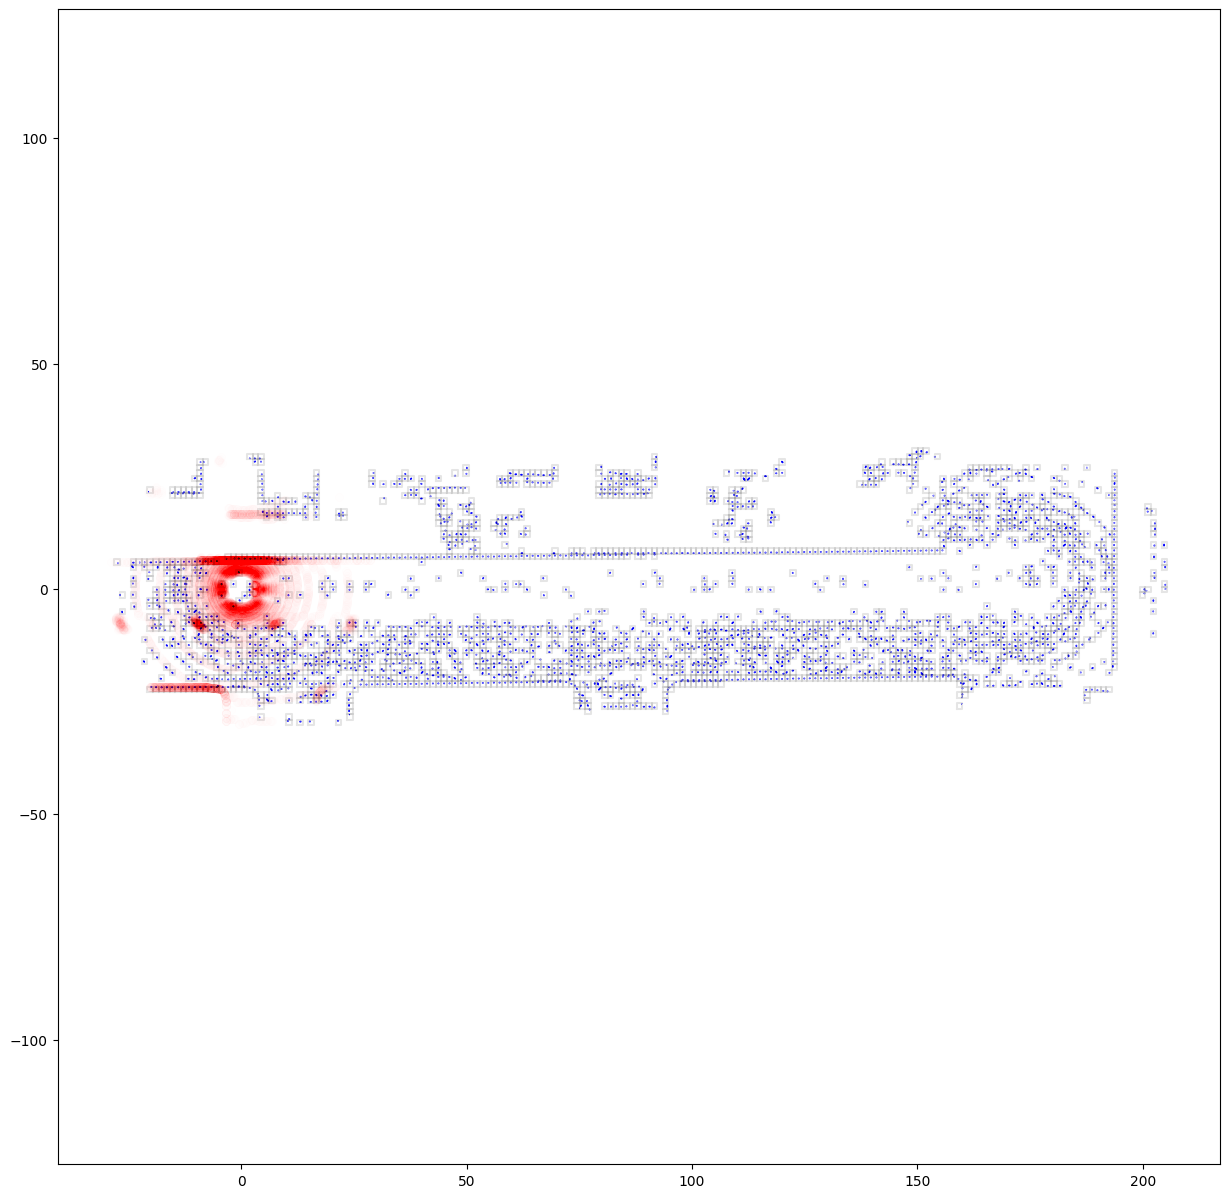

In [7]:
def plot_ndt(ndt_map: NDT_map):
    map = ndt_map.grid_map
    means = ndt_map.means
    covs = ndt_map.covs
    counts = ndt_map.counts
    nx = ndt_map.nx
    ny = ndt_map.ny
    resolution = ndt_map.resolution

    plt.figure(figsize=(15,15))
    # plot rectangles around cells
    for i in range(nx):
        for j in range(ny):
            if counts.cpu().numpy()[i,j] == 0:
                continue
            plt.plot(
            [map.cpu().numpy()[i,j,0]-resolution/2, map.cpu().numpy()[i,j,0]+resolution/2, map.cpu().numpy()[i,j,0]+resolution/2, map.cpu().numpy()[i,j,0]-resolution/2, map.cpu().numpy()[i,j,0]-resolution/2],
            [map.cpu().numpy()[i,j,1]-resolution/2, map.cpu().numpy()[i,j,1]-resolution/2, map.cpu().numpy()[i,j,1]+resolution/2, map.cpu().numpy()[i,j,1]+resolution/2, map.cpu().numpy()[i,j,1]-resolution/2],
            color='black', alpha=0.1
            )
            
    #plt.plot(
    #    target_pcd.cpu().numpy()[:,0],target_pcd.cpu().numpy()[:,1], 'o', color='red', alpha=0.01
    #)

    # draw covs
    for i in range(nx):
        for j in range(ny):
            if np.allclose(covs.cpu().numpy()[i,j,:], np.zeros((2,2))):
                continue
            a,b,c = covs.cpu().numpy()[i,j,0,0],covs.cpu().numpy()[i,j,0,1],covs.cpu().numpy()[i,j,1,1]
            width = (a+c)/2 + np.sqrt(((a-c)/2)**2 + b**2)
            height = (a+c)/2 - np.sqrt(((a-c)/2)**2 + b**2)
            width, height  = sorted([width, height])
            assert height > width
            width = max(width, 0.1)
            plt.gca().add_patch(Ellipse(
            xy=(means.cpu().numpy()[i,j,0], means.cpu().numpy()[i,j,1]),
            width= height,
            height= width,
            angle=np.arctan2(
            height - a, b
            ) * 180 / np.pi,
            color='blue'
        ))
            
    plt.axis('equal')

plot_ndt(ndt_map)

# load a frame
frame = 70
source_pcd = torch.tensor(utils.pcl_from_pcd(f"../dataset/frames/frame_{frame}.pcd"), device=device, dtype=torch.float32, requires_grad=True)[:,:2]

# translate
t = torch.tensor([0, 0, 0], device=device, dtype=torch.float32, requires_grad=True)
rotation_matrix = torch.tensor([[torch.cos(t[2]), -torch.sin(t[2])], [torch.sin(t[2]), torch.cos(t[2])]], device=device, requires_grad=True, dtype=torch.float32)

plt.plot(
    (source_pcd @ rotation_matrix).cpu().detach().numpy()[:,0]+t[:2].cpu().detach().numpy()[0],
    (source_pcd @ rotation_matrix).cpu().detach().numpy()[:,1]+t[:2].cpu().detach().numpy()[1], 'o', color='red', alpha=0.005
)

score = calculate_score(ndt_map, source_pcd, t)
print(f"{score=}")

score.backward(retain_graph=True)
print(t.grad)

In [8]:
df = pd.read_csv("../dataset/ground_truth.csv")
gt = df[["x", "y"]].to_numpy()

In [10]:
def train(ndt_map, frame, init_value, skipped):
    # load a frame
    source_pcd = torch.tensor(utils.pcl_from_pcd(f"../dataset/frames/frame_{frame}.pcd")[:,:2], device=device, dtype=torch.float32)
    t = torch.tensor([init_value[0], init_value[1], init_value[2]], device=device, dtype=torch.float32, requires_grad=True)

    # creating a value to fall back to if we can't find a good solution
    # this allows us to skip bad frames
    #if frame > 20:
    #    old_t = torch.tensor(track[-1] + (track[-1] - track[-20])/20, device=device, dtype=torch.float32, requires_grad=True)
    #else:
    #    old_t = t

    j = 0
    t_ = t.detach().clone()
    while True:
        score = calculate_score(ndt_map, source_pcd, t)
        score.backward()
        def calculate_score_mod(t, ndt_map=ndt_map, source_pcd = source_pcd):
            return calculate_score(ndt_map, source_pcd, t)
        
        try:
            dt = (torch.linalg.inv(torch.autograd.functional.hessian(calculate_score_mod, t)) @ t.grad)
        except:
            print("hessian failed")
            dt = torch.tensor([0.1,0,0], device=device, dtype=torch.float32)
        if torch.max(dt) > 0.2:
            #print("clipping dt")
            dt = dt / torch.max(dt) * 0.2
        t = (t - dt).detach().requires_grad_(True)
        
        if (torch.linalg.norm(dt) < 1e-3) or j > 50:
            if torch.linalg.norm(t - t_) > 1:
                t = t_
            skipped = False 
            break
        j += 1

    return t.cpu().detach().numpy(), skipped, j

[I 2023-04-28 14:00:48,160] A new study created in memory with name: no-name-fcb4ef97-60f3-44cc-8c9e-c2f7c66ad370


In [12]:
x_min, x_max, y_min, y_max = torch.min(target_pcd[:,0]), torch.max(target_pcd[:,0]), torch.min(target_pcd[:,1]), torch.max(target_pcd[:,1])
ndt_map = voxelize(target_pcd, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, resolution =  1.5, ratio = 2)

track = []

skipped = False
start = 0
val = [*gt[start],0]

for idx in range(start, 1014):
    acc = 0
    vel = 0
    if len(track) > 20:
        val = track[-1] + (vel := (track[-1] - track[-10])/9) + (acc := (4*track[-10]-9*track[-5]+5*track[-1])/(90*2))
    val, skipped, its = train(ndt_map, idx, val, skipped)
    print(f"idx {idx} iterations {its} error:", error := np.linalg.norm(val[:2]-gt[idx]), f"t: {val}, acc: {acc}, vel: {vel}")
    if error > 1.2:
        print("error too big")
    if error > 3:
        print("way too big")
        break
    track.append(val)

track = np.array(track)
df = pd.DataFrame(track, columns=["x", "y", "theta"])
df.to_csv("track.csv", index=False)

idx 0 iterations 5 error: 0.11068510482729371 t: [-1.1067329e-01  1.6169548e-03  4.7684007e-06], acc: 0, vel: 0
idx 1 iterations 19 error: 0.15503747223347425 t: [-1.5502010e-01  2.3206694e-03  6.3009566e-08], acc: 0, vel: 0
idx 2 iterations 5 error: 0.11046833531799997 t: [-1.1045474e-01  1.7331850e-03 -8.1469243e-06], acc: 0, vel: 0
idx 3 iterations 2 error: 0.12258369029672571 t: [-1.2256998e-01  1.8334562e-03  5.4365410e-07], acc: 0, vel: 0
idx 4 iterations 7 error: 0.056027032726494105 t: [-5.6019116e-02  9.4181584e-04 -1.0274691e-05], acc: 0, vel: 0
idx 5 iterations 51 error: 0.056027032726494105 t: [-5.6019116e-02  9.4181584e-04 -1.0274691e-05], acc: 0, vel: 0
idx 6 iterations 10 error: 0.14594611694935303 t: [-1.4593035e-01  2.1452394e-03  4.3600839e-06], acc: 0, vel: 0
idx 7 iterations 5 error: 0.18698907252668798 t: [-1.8696702e-01  2.8720109e-03 -7.7681934e-06], acc: 0, vel: 0
idx 8 iterations 5 error: 0.05389980714561327 t: [-5.3892814e-02  8.6824544e-04 -5.9210620e-06], ac

In [ ]:
# plot loss surface

frame = 810
source_pcd = torch.tensor(utils.pcl_from_pcd(f"../dataset/frames/frame_{frame}.pcd"), device=device, dtype=torch.float32, requires_grad=True)[:,:2]

gt_pos = gt[frame]

In [ ]:
scores = []

n = 20
for dx in np.linspace(-1, 1, n):
    for dy in np.linspace(-1, 1, n):
        t = torch.tensor([gt_pos[0]+dx, gt_pos[1]+dy, 0], device=device, dtype=torch.float32, requires_grad=True)
        score = calculate_score(ndt_map, source_pcd, t)
        scores.append(score.cpu().detach().numpy())
scores = np.array(scores).reshape(n,n)

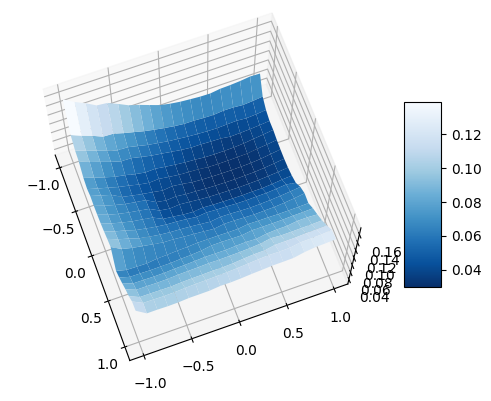

In [ ]:
# plot loss surface
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n))
Z = scores

surf = ax.plot_surface(X, Y, Z, cmap="Blues_r")
# change view angle
ax.view_init(azim=-20, elev=70)
# add colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:


loss_map = torch.zeros(
        (nx := int(torch.ceil((x_max - x_min) / resolution)),
        ny := int(torch.ceil((y_max - y_min) / resolution)), 2), device=device, dtype=torch.float32)
    # write cell centers to map
    map[:,:,0], map[:,:,1] = torch.meshgrid(
        torch.arange(x_min, x_max, resolution, device=device),
        torch.arange(y_min, y_max, resolution, device=device)
        )

IndentationError: unexpected indent (684258177.py, line 5)

In [ ]:

def animate_track(ndt_map: NDT_map, track=None):
    map = ndt_map.grid_map
    means = ndt_map.means
    covs = ndt_map.covs
    counts = ndt_map.counts
    nx = ndt_map.nx
    ny = ndt_map.ny
    resolution = ndt_map.resolution
    
    fig = plt.figure(figsize=(15,6))
    plt.axis("equal")
    for i in range(nx):
        for j in range(ny):
            if counts.cpu().numpy()[i,j] == 0:
                continue
            plt.plot(
                [map.cpu().numpy()[i,j,0]-resolution/2, map.cpu().numpy()[i,j,0]+resolution/2, map.cpu().numpy()[i,j,0]+resolution/2, map.cpu().numpy()[i,j,0]-resolution/2, map.cpu().numpy()[i,j,0]-resolution/2],
                [map.cpu().numpy()[i,j,1]-resolution/2, map.cpu().numpy()[i,j,1]-resolution/2, map.cpu().numpy()[i,j,1]+resolution/2, map.cpu().numpy()[i,j,1]+resolution/2, map.cpu().numpy()[i,j,1]-resolution/2],
                color='black', alpha=0.1
            )

    data = utils.pcl_from_pcd(f"../dataset/frames/frame_{0}.pcd")
    (measurement,) = plt.plot(data[:,0], data[:,1], 'o', color='red', alpha=0.01)
    (ground_truth,) = plt.plot(gt[:1,0], gt[:1,1], color='green')

    def animate(frame):
        print(f"starting frame: {frame}")
        t = track[frame]
        rotation_matrix = np.array([[np.cos(t[2]), -np.sin(t[2])], [np.sin(t[2]), np.cos(t[2])]])
        data = utils.pcl_from_pcd(f"../dataset/frames/frame_{frame}.pcd")[:,:2]
        data = data @ rotation_matrix
        measurement.set_data(data[:,0]+t[0], data[:,1]+t[1])
        ground_truth.set_data(gt[:frame,0], gt[:frame,1])
        error = np.linalg.norm(gt[frame,:2] - track[frame][:2])
        plt.gca().set_title(f"frame: {frame}, error: {error:.2f}m")
        return (measurement,ground_truth)

    anim = animation.FuncAnimation(fig, animate, frames=len(track), blit=True, interval=50)
    # save the animation as mp4 video file
    anim.save("ndt_animation.mp4", fps=60, extra_args=["-vcodec", "libx264"])
    return HTML(anim.to_jshtml())
    
    
animate_track(ndt_map, track)

# optimizing using lbgfs

In [ ]:
import optuna

def train(ndt_map, frame, init_value):
    source_pcd = torch.tensor(utils.pcl_from_pcd(f"../dataset/frames/frame_{frame}.pcd"), device=device, dtype=torch.float32, requires_grad=True)[:,:2]
    def objective(trial):
        x = trial.suggest_uniform('x', init_value[0]-.5, init_value[0]+.5)
        y = trial.suggest_uniform('y', init_value[1]-.5, init_value[1]+.5)
        t = torch.tensor([x,y], device=device, dtype=torch.float32, requires_grad=True)
        score = calculate_score(ndt_map, source_pcd, t)
        return score

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)

    x, y = study.best_params['x'], study.best_params['y']
    return x, y

track = []
val = [0,0]
for idx in range(26, 49):
    print(idx)
    val = train(ndt_map, idx, val)
    print(val)
    track.append(val)

In [ ]:

# plot yaw
plt.plot(df[" yaw"]*180/np.pi, label="yaw")
plt.plot(df[" roll"]*180/np.pi, label="roll")
plt.plot(df[" pitch"]*180/np.pi, label="pitch")
plt.legend()

In [ ]:
# plot x,y
plt.plot(df[" x"], df[" y"])
plt.axis('equal')

In [ ]:
import torch

angle = torch.tensor([0.2], requires_grad=True)
R = torch.zeros(2, 2)
R[0, 0] = torch.cos(angle)
R[0, 1] = -torch.sin(angle)
R[1, 0] = torch.sin(angle)
R[1, 1] = torch.cos(angle)
v = torch.tensor([1.0, 2.0], requires_grad=True)

w = torch.matmul(R, v)
output = torch.sum(w)

output.backward()

print(v.grad) # should print the gradient of output with respect to v
print(angle.grad) # should print the gradient of output with respect to angle